In [1]:
import torch
import torch.nn as nn
import torch.utils.data
import numpy as np

import matplotlib.pyplot as plt
import tqdm

from nvidia.dali.plugin.pytorch import DALIClassificationIterator
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types

In [5]:
#hyperparameters

BATCH_SIZE = 64
CROP_SHAPE = (28, 28)
LEARN_RATE = 0.001
BN_MOMENTUM = 0.1
CONV_KERNEL = 3

DALI_THDS = 3

LABEL_MAP = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device.type)

cuda


In [7]:
# DALI Pipeline


_mean_pixel = [255 * x for x in (0.485, 0.456, 0.406)]
_std_pixel  = [255 * x for x in (0.229, 0.224, 0.225)]


class HybridTrainPipe(Pipeline):
    def __init__(self, rec_path, idx_path, batch_size, crop_shape, resize_shp=None,
                 output_layout=types.NCHW, pad_output=False, dtype='float32', mem_padding=16,
                 num_threads=3, device_id=0, shard_id=0, num_shards=1):        
        super(HybridTrainPipe, self).__init__(batch_size, num_threads, device_id, seed=12+device_id)
        
        self.input = ops.MXNetReader(path=[rec_path], index_path=[idx_path],
                                     random_shuffle=True, shard_id=shard_id, num_shards=num_shards)
        self.decode = ops.nvJPEGDecoder(device="mixed", output_type=types.RGB,
                                        device_memory_padding=mem_padding*1024*1024,
                                        host_memory_padding=mem_padding*1024*1024)
        self.rotate = ops.Rotate(device="gpu")
        self.distrib = ops.Uniform(range=(-10.0,10.0))
        self.rrc = ops.RandomResizedCrop(device="gpu", size=crop_shape, random_area=[0.2, 1])
        self.cmnp = ops.CropMirrorNormalize(device        = "gpu",
                                            output_dtype  = types.FLOAT16 if dtype == 'float16' else types.FLOAT,
                                            output_layout = output_layout,
                                            crop          = crop_shape,
                                            image_type    = types.RGB,
                                            mean          = _mean_pixel,
                                            std           = _std_pixel)
        self.coin = ops.CoinFlip(probability=0.5)

    def define_graph(self):
        self.jpegs, self.labels = self.input(name="Reader")
        images = self.decode(self.jpegs)
        #images = self.rotate(images, angle=self.distrib())
        images = self.rrc(images)
        images = self.cmnp(images.gpu(), mirror=self.coin())
        return [images, self.labels]
    

class HybridValidPipe(Pipeline):
    def __init__(self, rec_path, idx_path, batch_size, crop_shape, resize_shp=None,
                 output_layout=types.NCHW, pad_output=False, dtype='float32', mem_padding=16,
                 num_threads=3, device_id=0, shard_id=0, num_shards=1):
        super(HybridValidPipe, self).__init__(batch_size, num_threads, device_id, seed=12+device_id)
        self.input = ops.MXNetReader(path = [rec_path], index_path=[idx_path],
                                     random_shuffle=False, shard_id=shard_id, num_shards=num_shards)
        self.decode = ops.nvJPEGDecoder(device = "mixed", output_type = types.RGB,
                                        device_memory_padding=mem_padding*1024*1024,
                                        host_memory_padding=mem_padding*1024*1024)
        self.resize = ops.Resize(device = "gpu", resize_shorter=resize_shp) if resize_shp else None
        self.cmnp = ops.CropMirrorNormalize(device        = "gpu",
                                            output_dtype  = types.FLOAT16 if dtype == 'float16' else types.FLOAT,
                                            output_layout = output_layout,
                                            crop          = crop_shape,
                                            pad_output    = pad_output,
                                            image_type    = types.RGB,
                                            mean          = _mean_pixel,
                                            std           = _std_pixel)

    def define_graph(self):
        self.jpegs, self.labels = self.input(name = "Reader")
        images = self.decode(self.jpegs)
        if self.resize:
            images = self.resize(images)
        images = self.cmnp(images)
        return [images, self.labels]

In [186]:
# model

Activation = nn.ReLU
Pooling = nn.MaxPool2d

class BottleneckUnit(nn.Module):
    def __init__(self, in_C, out_C, down_C=None, down_times=4, k=CONV_KERNEL, s=1):
        super(BottleneckUnit, self).__init__()
        down_C = down_C if down_C is not None else out_C//down_times
        self.addZeros = (lambda x: torch.cat([x, torch.zeros(x.shape[:1]+torch.Size([out_C-in_C])+x.shape[2:]).cuda()], dim=1)) if in_C != out_C else None
        self.pool_s = Pooling((3,3), stride=s, padding=(1,1)) if s > 1 else None
        
        self.conv1 = nn.Conv2d(in_C, down_C, 1, padding=0, stride=1)
        self.bn1 = nn.BatchNorm2d(down_C, momentum=BN_MOMENTUM)
        self.activ1 = Activation()
        self.pool_1 = Pooling((3,3), stride=s, padding=(1,1)) if s > 1 else None
        self.conv2 = nn.Conv2d(down_C, down_C, k, padding=1)
        self.bn2 = nn.BatchNorm2d(down_C, momentum=BN_MOMENTUM)
        self.activ2 = Activation()
        self.conv3 = nn.Conv2d(down_C, out_C, 1, padding=0, stride=1)
        self.bn3 = nn.BatchNorm2d(out_C, momentum=BN_MOMENTUM)
        self.activ3 = Activation()
        
    def forward(self, x):
        shortcut = x
        if self.addZeros is not None:
            shortcut = self.addZeros(shortcut)
        if self.pool_s is not None:
            shortcut = self.pool_s(shortcut)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activ1(x)
        if self.pool_1 is not None:
            x = self.pool_s(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activ2(x)
        x = self.conv3(x)
        return self.activ3(self.bn3(x)+shortcut)
        

class ResidualStrideUnit(nn.Module):
    def __init__(self, in_C, out_C, k=CONV_KERNEL, s=1):
        super(ResidualStrideUnit, self).__init__()
        self.conv_s = nn.Conv2d(in_C, out_C, 1, stride=s) if in_C != out_C else None
        #self.bn_s = nn.BatchNorm2d(out_C, momentum=BN_MOMENTUM) if in_C != out_C else None
        #self.pool_s = Pooling((3,3), stride=s, padding=(1,1)) if s > 1 else None
        
        self.conv1 = nn.Conv2d(in_C, out_C, k, padding=1, stride=s)
        self.bn1 = nn.BatchNorm2d(out_C, momentum=BN_MOMENTUM)
        self.activ1 = Activation()
        self.conv2 = nn.Conv2d(out_C, out_C, k, padding=1)
        self.bn2 = nn.BatchNorm2d(out_C, momentum=BN_MOMENTUM)
        self.activ2 = Activation()
        
    def forward(self, x):
        if self.conv_s:
            shortcut = self.conv_s(x)
            #shortcut = self.bn_s(shortcut)
            #if self.pool_s:
            #    shortcut = self.pool_s(shortcut)
        else:
            shortcut = x
            
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activ1(x)
        x = self.conv2(x)
        return self.activ2(self.bn2(x)+shortcut)

    
class ResidualUnit(nn.Module):
    def __init__(self, in_C, out_C, k=CONV_KERNEL, s=1):
        super(ResidualUnit, self).__init__()
        self.addZeros = (lambda x: torch.cat([x, torch.zeros(x.shape[:1]+torch.Size([out_C-in_C])+x.shape[2:]).cuda()], dim=1)) if in_C != out_C else None
        self.pool_s = Pooling((3,3), stride=s, padding=(1,1)) if s > 1 else None
        
        self.conv1 = nn.Conv2d(in_C, out_C, k, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(out_C, momentum=BN_MOMENTUM)
        self.activ1 = Activation()
        self.pool_1 = Pooling((3,3), stride=s, padding=(1,1)) if s > 1 else None
        self.conv2 = nn.Conv2d(out_C, out_C, k, padding=1)
        self.bn2 = nn.BatchNorm2d(out_C, momentum=BN_MOMENTUM)
        self.activ2 = Activation()
    
    def forward(self, x):
        shortcut = x
        if self.addZeros is not None:
            shortcut = self.addZeros(shortcut)
        if self.pool_s is not None:
            shortcut = self.pool_s(shortcut)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activ1(x)
        if self.pool_1 is not None:
            x = self.pool_s(x)
        x = self.conv2(x)
        return self.activ2(self.bn2(x)+shortcut)

    
class PreactUnit(nn.Module):
    def __init__(self, in_C, out_C, k=CONV_KERNEL, s=1):
        super(PreactUnit, self).__init__()
        self.addZeros = (lambda x: torch.cat([x, torch.zeros(x.shape[:1]+torch.Size([out_C-in_C])+x.shape[2:]).cuda()], dim=1)) if in_C != out_C else None
        self.pool_s = Pooling((3,3), stride=s, padding=(1,1)) if s > 1 else None
        
        self.bn1 = nn.BatchNorm2d(in_C, momentum=BN_MOMENTUM)
        self.activ1 = Activation()
        self.conv1 = nn.Conv2d(in_C, out_C, k, padding=1, stride=1)
        self.pool_1 = Pooling((3,3), stride=s, padding=(1,1)) if s > 1 else None
        self.bn2 = nn.BatchNorm2d(out_C, momentum=BN_MOMENTUM)
        self.activ2 = Activation()
        self.conv2 = nn.Conv2d(out_C, out_C, k, padding=1)
        
    def forward(self, x):
        shortcut = x
        if self.addZeros is not None:
            shortcut = self.addZeros(shortcut)
        if self.pool_s is not None:
            shortcut = self.pool_s(shortcut)
        
        x = self.bn1(x)
        x = self.activ1(x)
        x = self.conv1(x)
        if self.pool_1 is not None:
            x = self.pool_s(x)
        x = self.bn2(x)
        x = self.activ2(x)
        x = self.conv2(x)
        return x+shortcut


UNIT = ResidualUnit
DASHED_UNIT = ResidualUnit

CONV_SIZES = [32, 64, 128, 256, 512]
FULLY_SIZES = [CONV_SIZES[-1]*4, 1024]
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        convs = []
        fully = []
        convs.append(nn.Conv2d(3, CONV_SIZES[0], 5, padding=2))
        convs.append(nn.BatchNorm2d(CONV_SIZES[0], momentum=BN_MOMENTUM))
        convs.append(Activation())
        convs.append(UNIT(CONV_SIZES[0], CONV_SIZES[0]))
        convs.append(UNIT(CONV_SIZES[0], CONV_SIZES[0]))
        convs.append(UNIT(CONV_SIZES[0], CONV_SIZES[0]))
        convs.append(UNIT(CONV_SIZES[0], CONV_SIZES[0]))
        
#         convs.append(nn.Conv2d(CONV_SIZES[0], CONV_SIZES[1], CONV_KERNEL, padding=(1, 1)))
#         convs.append(nn.BatchNorm2d(CONV_SIZES[1], momentum=BN_MOMENTUM))
#         convs.append(Pooling((3,3), stride=(2,2), padding=(1,1)))
#         #convs.append(Pooling((2,2), stride=(2,2)))#, padding=(1,1)))
#         convs.append(Activation())
        convs.append(DASHED_UNIT(CONV_SIZES[0], CONV_SIZES[1], s=2))
        convs.append(UNIT(CONV_SIZES[1], CONV_SIZES[1]))
        convs.append(UNIT(CONV_SIZES[1], CONV_SIZES[1]))
        convs.append(UNIT(CONV_SIZES[1], CONV_SIZES[1]))
        convs.append(UNIT(CONV_SIZES[1], CONV_SIZES[1]))
        
#         convs.append(nn.Conv2d(CONV_SIZES[1], CONV_SIZES[2], CONV_KERNEL, padding=(1, 1)))
#         convs.append(nn.BatchNorm2d(CONV_SIZES[2], momentum=BN_MOMENTUM))
#         convs.append(Pooling((3,3), stride=(2,2), padding=(1,1)))
#         #convs.append(Pooling((2,2), stride=(2,2)))#, padding=(1,1)))
#         convs.append(Activation())
        convs.append(DASHED_UNIT(CONV_SIZES[1], CONV_SIZES[2], s=2))
        convs.append(UNIT(CONV_SIZES[2], CONV_SIZES[2]))
        convs.append(UNIT(CONV_SIZES[2], CONV_SIZES[2]))
        
#         convs.append(nn.Conv2d(CONV_SIZES[2], CONV_SIZES[3], CONV_KERNEL, padding=(1, 1)))
#         convs.append(nn.BatchNorm2d(CONV_SIZES[3], momentum=BN_MOMENTUM))
#         convs.append(Pooling((3,3), stride=(2,2), padding=(1,1)))
#         convs.append(Pooling((2,2), stride=(2,2)))#, padding=(1,1)))
#         convs.append(Activation())
        convs.append(DASHED_UNIT(CONV_SIZES[2], CONV_SIZES[3], s=2))
        convs.append(UNIT(CONV_SIZES[3], CONV_SIZES[3]))
        convs.append(UNIT(CONV_SIZES[3], CONV_SIZES[3]))
        
        convs.append(DASHED_UNIT(CONV_SIZES[3], CONV_SIZES[4], s=2))
#         convs.append(UNIT(CONV_SIZES[4], CONV_SIZES[4]))
#         convs.append(UNIT(CONV_SIZES[4], CONV_SIZES[4]))
        
#         convs.append(nn.Conv2d(CONV_SIZES[3], CONV_SIZES[4], CONV_KERNEL, padding=(1, 1)))
#         convs.append(nn.BatchNorm2d(CONV_SIZES[4], momentum=BN_MOMENTUM))
#         convs.append(Pooling((3,3), stride=(2,2), padding=(1,1)))
#         convs.append(Activation())    
    
#         fully.append(nn.Linear(FULLY_SIZES[0], FULLY_SIZES[0]))
        #fully.append(nn.Dropout(0.2))
        fully.append(nn.BatchNorm1d(FULLY_SIZES[0]))
#         fully.append(Activation())
        fully.append(nn.Linear(FULLY_SIZES[0], 10))
        fully.append(nn.Softmax(dim=1))
        
        self.convs = nn.ModuleList(convs)
        self.fully = nn.ModuleList(fully)
        self.eval()
    
    def forward(self, x):
        for layer in self.convs:
            x = layer(x)
        x = x.view(x.shape[0], -1)
        for layer in self.fully:
            x = layer(x)
        return x

In [187]:
def epoch(model, data_loader, criterion, optimizer, epoch_size, printstep=1, loss_ema=None, loss_momentum=0.9):
    model.train()
    correct = 0
    total = 0
    #for i, batch in enumerate(data_loader):
    for i, batch in tqdm.tqdm_notebook(enumerate(data_loader), total=int(epoch_size), leave=False):
        imgs, lbls = batch[0]
        imgs, lbls = imgs[0], lbls[0].type(torch.cuda.LongTensor)
        
        outs = model(imgs)
        loss = criterion(outs, lbls)
        loss_ema = loss_momentum*loss_ema + (1-loss_momentum)*loss if loss_ema else loss

        _, preds = torch.max(outs.data, 1)
        total += lbls.size(0)
        correct += (preds == lbls).sum().item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i%printstep == 0:
            print("\r{0:3d}/{1:3d}; loss: {2:.5f}".format(i, epoch_size, loss_ema.item()), end='')
    data_loader.reset()
    model.eval()
    return correct / total
    
def evaluate(model, data_loader, epoch_size):
    with torch.no_grad():
        correct = 0
        total = 0
        for i, batch in tqdm.tqdm_notebook(enumerate(data_loader), total=int(epoch_size), leave=False):
            imgs, lbls = batch[0]
            imgs, lbls = imgs[0], lbls[0].type(torch.cuda.LongTensor)
            outs = model(imgs)
            _, preds = torch.max(outs.data, 1)
            total += lbls.size(0)
            correct += (preds == lbls).sum().item()
        data_loader.reset()
    return correct / total

In [188]:
daliTrainPipe = HybridTrainPipe("/home/dawid/Dokumenty/DeepLearning/data/cifar_rec/train.rec",
                                "/home/dawid/Dokumenty/DeepLearning/data/cifar_rec/train.idx",
                                BATCH_SIZE, CROP_SHAPE, num_threads=DALI_THDS)

daliValidPipe = HybridValidPipe("/home/dawid/Dokumenty/DeepLearning/data/cifar_rec/valid.rec",
                                "/home/dawid/Dokumenty/DeepLearning/data/cifar_rec/valid.idx",
                                BATCH_SIZE, CROP_SHAPE, num_threads=DALI_THDS)

daliTrainPipe.build()
daliValidPipe.build()

daliTrainIter = DALIClassificationIterator(daliTrainPipe, size=daliTrainPipe.epoch_size("Reader"))
daliValidIter = DALIClassificationIterator(daliValidPipe, size=daliValidPipe.epoch_size("Reader"))

In [189]:
classifier = Classifier().to(device)
crossEntropy = nn.CrossEntropyLoss()

In [190]:
#classifier.convs

In [191]:
#adam = torch.optim.Adam(classifier.parameters(), lr=LEARN_RATE)
#sgd = torch.optim.SGD(classifier.parameters(), lr=0.001) 

In [192]:
train_results = [evaluate(classifier, daliTrainIter, daliTrainPipe.epoch_size("Reader")//BATCH_SIZE)]
valid_results = [evaluate(classifier, daliValidIter, daliValidPipe.epoch_size("Reader")//BATCH_SIZE)]
print("train: {0:.5f}    valid: {1:.5f}".format(train_results[-1], valid_results[-1]))

train: 0.06712    valid: 0.06837


In [193]:
sgd = torch.optim.SGD(classifier.parameters(), lr=0.2)
for i in tqdm.tqdm_notebook(range(100)):
    train_results += [epoch(classifier, daliTrainIter, crossEntropy, sgd, daliTrainPipe.epoch_size("Reader")//BATCH_SIZE)]
    valid_results += [evaluate(classifier, daliValidIter, daliValidPipe.epoch_size("Reader")//BATCH_SIZE)]
    print("{2} : train: {0:.5f}    valid: {1:.5f}".format(train_results[-1], valid_results[-1], i+1))
sgd = torch.optim.SGD(classifier.parameters(), lr=0.05)
for i in tqdm.tqdm_notebook(range(40)):
    train_results += [epoch(classifier, daliTrainIter, crossEntropy, sgd, daliTrainPipe.epoch_size("Reader")//BATCH_SIZE)]
    valid_results += [evaluate(classifier, daliValidIter, daliValidPipe.epoch_size("Reader")//BATCH_SIZE)]
    print("{2} : train: {0:.5f}    valid: {1:.5f}".format(train_results[-1], valid_results[-1], i+1))
sgd = torch.optim.SGD(classifier.parameters(), lr=0.01)
for i in tqdm.tqdm_notebook(range(20)):
    train_results += [epoch(classifier, daliTrainIter, crossEntropy, sgd, daliTrainPipe.epoch_size("Reader")//BATCH_SIZE)]
    valid_results += [evaluate(classifier, daliValidIter, daliValidPipe.epoch_size("Reader")//BATCH_SIZE)]
    print("{2} : train: {0:.5f}    valid: {1:.5f}".format(train_results[-1], valid_results[-1], i+1))

780/781; loss: 2.02871

1 : train: 0.36078    valid: 0.44161


780/781; loss: 1.94985

2 : train: 0.48103    valid: 0.50310


780/781; loss: 1.89381

3 : train: 0.54243    valid: 0.57482


781/781; loss: 1.85081

4 : train: 0.57721    valid: 0.61555


780/781; loss: 1.81227

5 : train: 0.61010    valid: 0.68039


780/781; loss: 1.81028

6 : train: 0.62648    valid: 0.66246


780/781; loss: 1.79925

7 : train: 0.64093    valid: 0.67598


781/781; loss: 1.78968

8 : train: 0.65805    valid: 0.73696


780/781; loss: 1.76631

9 : train: 0.67033    valid: 0.75821


780/781; loss: 1.75631

10 : train: 0.68070    valid: 0.74018


780/781; loss: 1.77816

11 : train: 0.69082    valid: 0.75180


781/781; loss: 1.74732

12 : train: 0.69719    valid: 0.76801


780/781; loss: 1.74791

13 : train: 0.69958    valid: 0.77464


780/781; loss: 1.75945

14 : train: 0.71067    valid: 0.75210


780/781; loss: 1.74080

15 : train: 0.71427    valid: 0.77895


781/781; loss: 1.73716

16 : train: 0.72133    valid: 0.77199


780/781; loss: 1.72051

17 : train: 0.72355    valid: 0.76162


780/781; loss: 1.70912

18 : train: 0.73089    valid: 0.79107


780/781; loss: 1.71038

19 : train: 0.73442    valid: 0.80078


781/781; loss: 1.73066

20 : train: 0.73797    valid: 0.79936


780/781; loss: 1.72101

21 : train: 0.74072    valid: 0.80108


780/781; loss: 1.71004

22 : train: 0.74474    valid: 0.81210


780/781; loss: 1.70108

23 : train: 0.74888    valid: 0.80339


781/781; loss: 1.70363

24 : train: 0.75446    valid: 0.79558


780/781; loss: 1.71364

25 : train: 0.75794    valid: 0.82712


780/781; loss: 1.69968

26 : train: 0.75982    valid: 0.81831


780/781; loss: 1.68469

27 : train: 0.76338    valid: 0.81450


781/781; loss: 1.68460

28 : train: 0.76688    valid: 0.83131


780/781; loss: 1.69400

29 : train: 0.76719    valid: 0.83684


780/781; loss: 1.67883

30 : train: 0.77149    valid: 0.83113


780/781; loss: 1.69062

31 : train: 0.77237    valid: 0.81340


781/781; loss: 1.68722

32 : train: 0.77296    valid: 0.82295


780/781; loss: 1.66626

33 : train: 0.77201    valid: 0.83644


780/781; loss: 1.66815

34 : train: 0.77981    valid: 0.83574


780/781; loss: 1.66366

35 : train: 0.78239    valid: 0.83994


781/781; loss: 1.66824

36 : train: 0.78425    valid: 0.83439


780/781; loss: 1.68355

37 : train: 0.78607    valid: 0.83163


780/781; loss: 1.66779

38 : train: 0.78877    valid: 0.84054


780/781; loss: 1.67145

39 : train: 0.78817    valid: 0.84185


781/781; loss: 1.66769

40 : train: 0.79280    valid: 0.83867


780/781; loss: 1.64584

41 : train: 0.79425    valid: 0.84996


780/781; loss: 1.63979

42 : train: 0.79681    valid: 0.84405


780/781; loss: 1.66696

43 : train: 0.79589    valid: 0.83924


781/781; loss: 1.66587

44 : train: 0.80025    valid: 0.84066


780/781; loss: 1.65950

45 : train: 0.80042    valid: 0.85457


780/781; loss: 1.66794

46 : train: 0.80292    valid: 0.85407


780/781; loss: 1.65794

47 : train: 0.80250    valid: 0.85116


781/781; loss: 1.66496

48 : train: 0.80435    valid: 0.84484


780/781; loss: 1.64663

49 : train: 0.80690    valid: 0.86228


780/781; loss: 1.64950

50 : train: 0.80946    valid: 0.85266


780/781; loss: 1.65158

51 : train: 0.80910    valid: 0.85447


781/781; loss: 1.65976

52 : train: 0.81184    valid: 0.86196


780/781; loss: 1.66171

53 : train: 0.81048    valid: 0.84736


780/781; loss: 1.64629

54 : train: 0.81436    valid: 0.86028


780/781; loss: 1.62881

55 : train: 0.80992    valid: 0.85627


781/781; loss: 1.63326

56 : train: 0.81370    valid: 0.85470


780/781; loss: 1.64281

57 : train: 0.81526    valid: 0.85306


780/781; loss: 1.64567

58 : train: 0.82110    valid: 0.84816


780/781; loss: 1.64068

59 : train: 0.81776    valid: 0.86338


781/781; loss: 1.63268

60 : train: 0.81903    valid: 0.87410


780/781; loss: 1.64095

61 : train: 0.82120    valid: 0.86548


780/781; loss: 1.62433

62 : train: 0.82244    valid: 0.86048


780/781; loss: 1.63275

63 : train: 0.82398    valid: 0.85897


781/781; loss: 1.63501

64 : train: 0.82457    valid: 0.87361


780/781; loss: 1.62755

65 : train: 0.82542    valid: 0.85557


780/781; loss: 1.62671

66 : train: 0.82913    valid: 0.87009


780/781; loss: 1.62549

67 : train: 0.82831    valid: 0.86739


781/781; loss: 1.62522

68 : train: 0.82755    valid: 0.86923


780/781; loss: 1.62961

69 : train: 0.82728    valid: 0.87360


780/781; loss: 1.62619

70 : train: 0.83249    valid: 0.87119


780/781; loss: 1.61944

71 : train: 0.83157    valid: 0.87129


781/781; loss: 1.62587

72 : train: 0.83394    valid: 0.86535


780/781; loss: 1.62508

73 : train: 0.83459    valid: 0.86218


780/781; loss: 1.60623

74 : train: 0.83711    valid: 0.88031


780/781; loss: 1.62818

75 : train: 0.83601    valid: 0.87560


781/781; loss: 1.62611

76 : train: 0.83965    valid: 0.87878


780/781; loss: 1.61574

77 : train: 0.83833    valid: 0.87620


780/781; loss: 1.61248

78 : train: 0.83779    valid: 0.87810


780/781; loss: 1.62406

79 : train: 0.83875    valid: 0.86398


781/781; loss: 1.62717

80 : train: 0.84007    valid: 0.87580


780/781; loss: 1.61838

81 : train: 0.83959    valid: 0.87119


170/781; loss: 1.60911

KeyboardInterrupt: 

In [ ]:
for i in tqdm.tqdm_notebook(range(70)):
    epoch(classifier, daliTrainIter, crossEntropy, adam, daliTrainPipe.epoch_size("Reader")//BATCH_SIZE)
    if (i+1) % 1 == 0:
        train_results += [evaluate(classifier, daliTrainIter, daliTrainPipe.epoch_size("Reader")//BATCH_SIZE)]
    else:
        train_results.append(train_results[-1])
    valid_results += [evaluate(classifier, daliValidIter, daliValidPipe.epoch_size("Reader")//BATCH_SIZE)]
    print("{2} : train: {0:.5f}    valid: {1:.5f}".format(train_results[-1], valid_results[-1], i+1))

In [155]:
train_results_halfbottleneck = np.array(train_results)
valid_results_halfbottleneck = np.array(valid_results)

In [52]:
train_deeper = np.array(train_results)
valid_deeper = np.array(valid_results)

In [51]:
np.save("deeper", [train_deeper, valid_deeper])

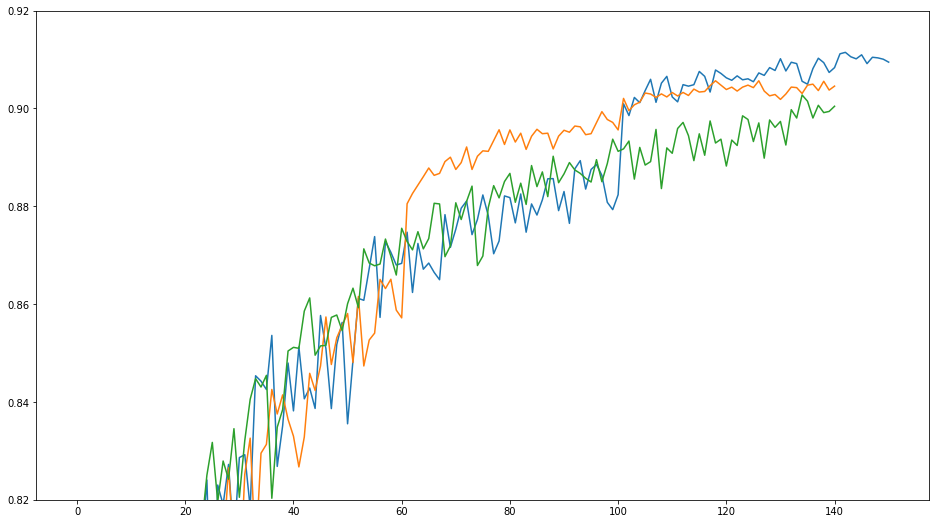

In [53]:
fig = plt.figure(figsize=(16, 9))
plt.plot(np.arange(len(valid_deeper)), valid_deeper)
plt.plot(np.arange(len(valid_sgd64d)), valid_sgd64d)
plt.plot(np.arange(len(best_valid_results)), best_valid_results)
plt.ylim(0.82, 0.92)
fig.show()

In [44]:
torch.save(classifier.state_dict(), "state_dict916.tsd")

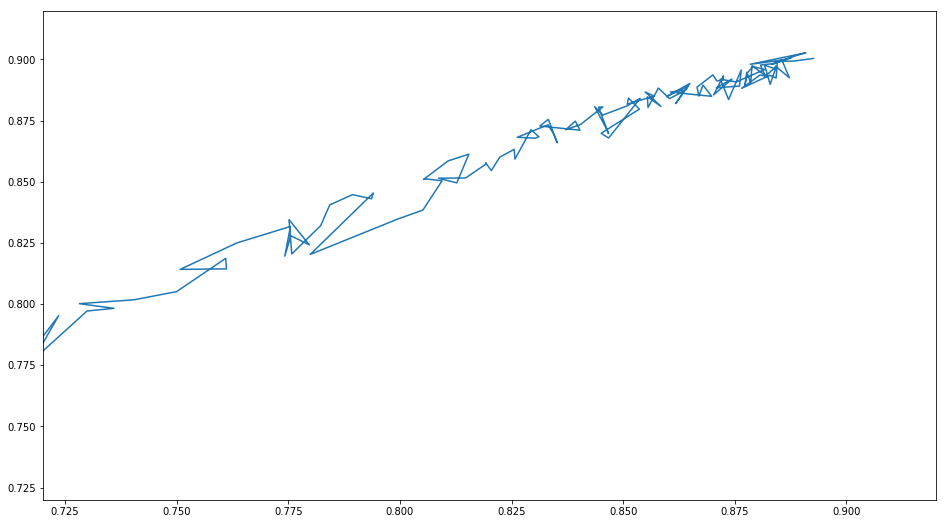

In [207]:
fig = plt.figure(figsize=(16, 9))
plt.plot(best_train_results, best_valid_results)
plt.ylim(0.72, 0.92)
plt.xlim(0.72, 0.92)
fig.show()

In [205]:
np.save("best", [best_train_results, best_valid_results])
np.save("halfbottleneck", [train_results_halfbottleneck, valid_results_halfbottleneck])

In [ ]:
train_deeper = np.load("deeper.npy")[0]
valid_deeper = np.load("deeper.npy")[1]

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


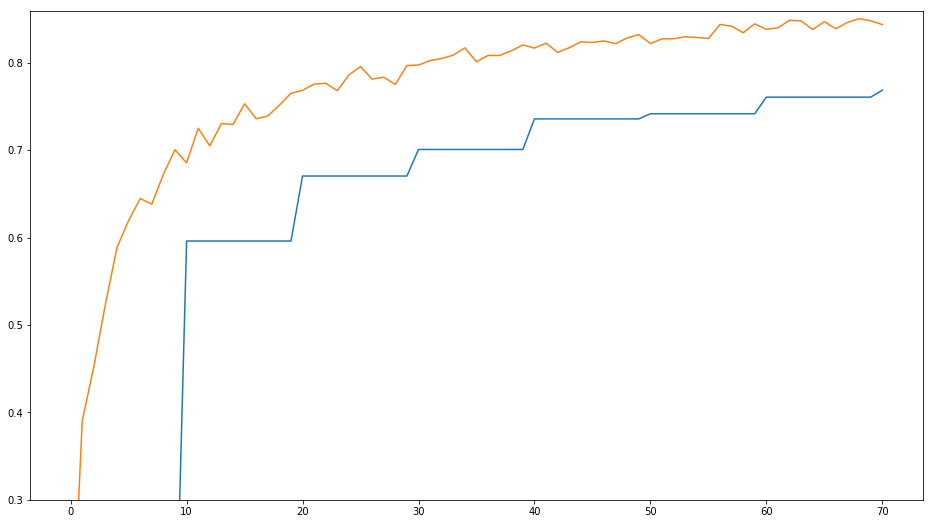

In [156]:
fig = plt.figure(figsize=(16, 9))
plt.plot(np.arange(len(train_results)), train_results)
plt.plot(np.arange(len(valid_results)), valid_results)
plt.ylim(0.3, 0.86)
fig.show()

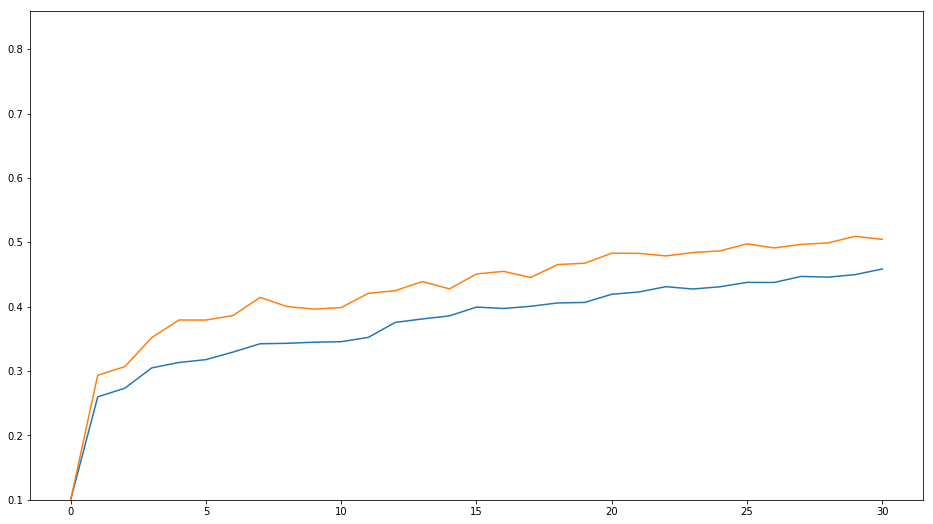

In [119]:
# VGG: (32,32); [64, 128, 256, 512]; 5*pooling; [512,10]

fig = plt.figure(figsize=(16, 9))
plt.plot(np.arange(len(train_results)), train_results)
plt.plot(np.arange(len(valid_results)), valid_results)
plt.ylim(0.1, 0.86)
fig.show()

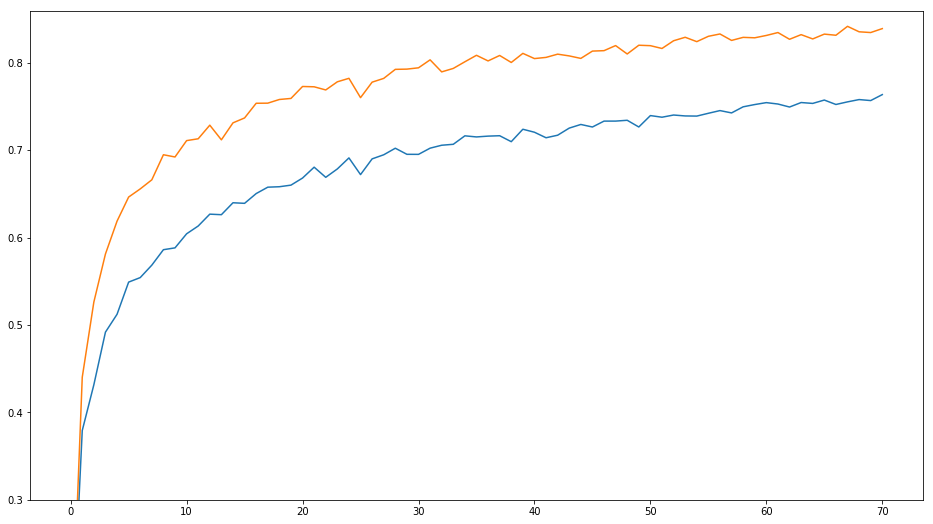

In [61]:
# dashed skip connections

fig = plt.figure(figsize=(16, 9))
plt.plot(np.arange(len(train_results)), train_results)
plt.plot(np.arange(len(valid_results)), valid_results)
plt.ylim(0.3, 0.86)
fig.show()

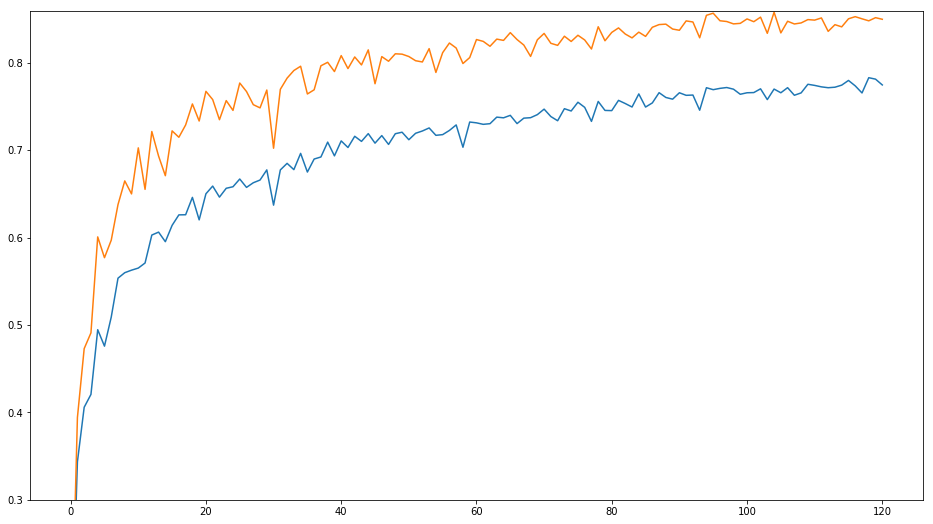

In [16]:
# BN_MOMENTUM = 0.01
fig = plt.figure(figsize=(16, 9))
plt.plot(np.arange(len(train_results)), train_results)
plt.plot(np.arange(len(valid_results)), valid_results)
plt.ylim(0.3, 0.86)
fig.show()

In [43]:
train_sgd64 = np.array(train_results[:-2])
valid_sgd64 = np.array(valid_results[:-2])

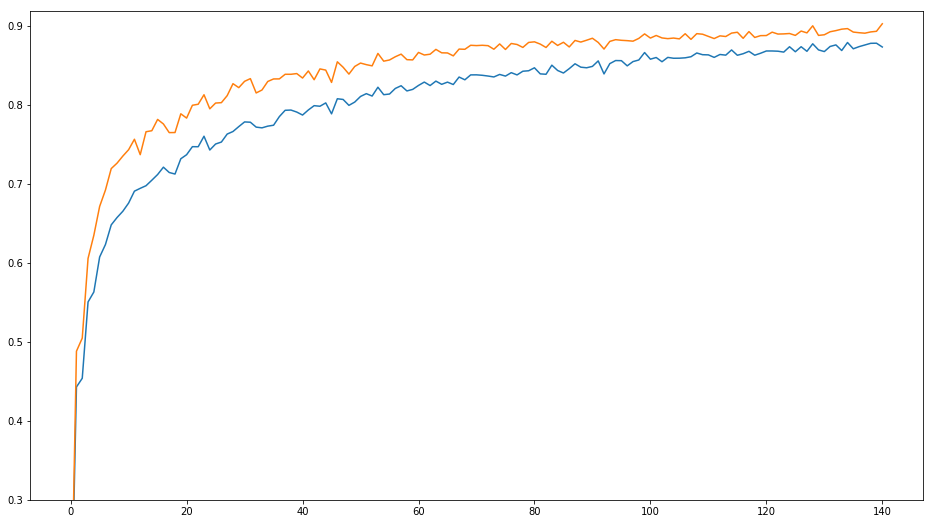

In [73]:
# 4 first residual units

fig = plt.figure(figsize=(16, 9))
plt.plot(np.arange(len(best_train_results)), best_train_results)
plt.plot(np.arange(len(best_valid_results)), best_valid_results)
plt.ylim(0.3, 0.92)
fig.show()

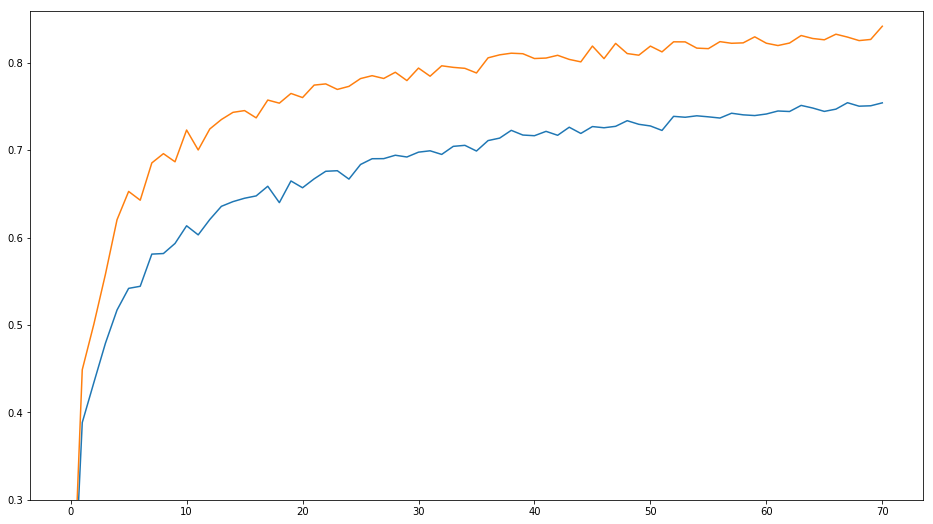

In [22]:
#default

fig = plt.figure(figsize=(16, 9))

plt.plot(np.arange(len(best_train_results)), best_train_results)
plt.plot(np.arange(len(best_valid_results)), best_valid_results)
plt.ylim(0.3, 0.86)
fig.show()

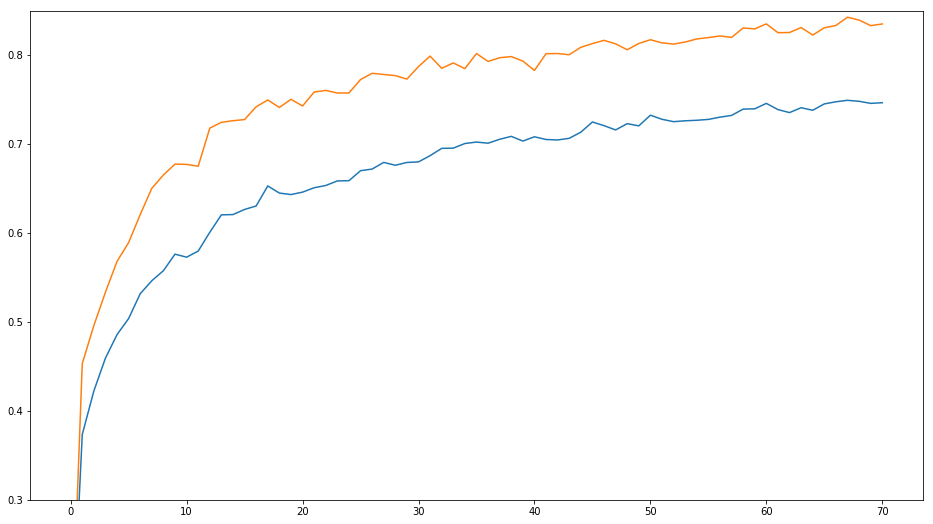

In [60]:
# first kernel 5
fig = plt.figure(figsize=(16, 9))
plt.plot(np.arange(len(train_results)), train_results)
plt.plot(np.arange(len(valid_results)), valid_results)
plt.ylim(0.3, 0.85)
fig.show()

dog
truck
airplane
cat
cat
cat
truck
ship
truck
truck
truck
dog
automobile
cat
airplane
dog


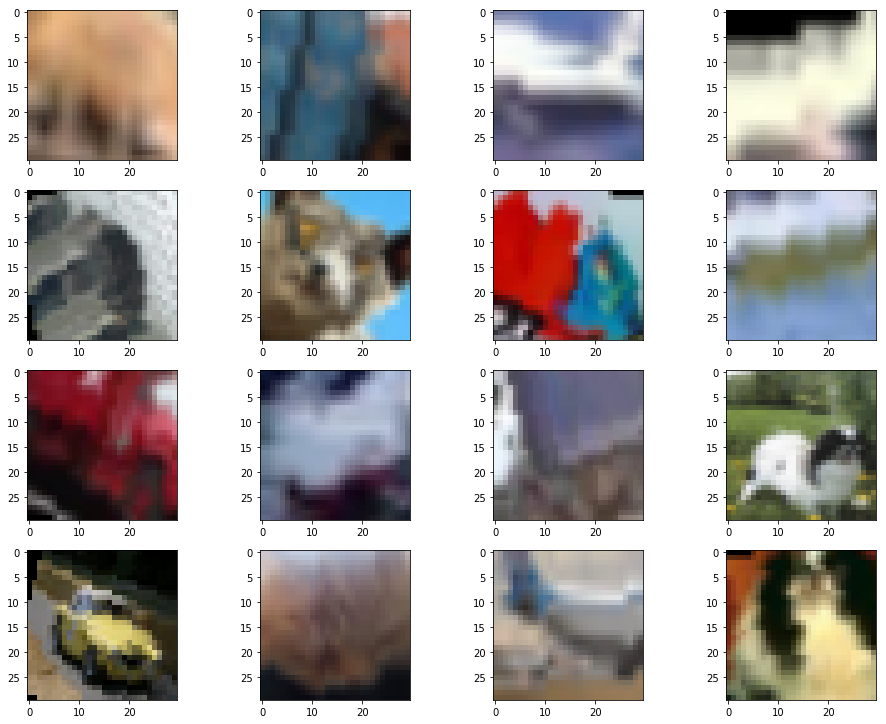

In [38]:
fig=plt.figure(figsize=(16, 16))
for i, batch in enumerate(daliTrainIter):
    imgs, lbls = batch[0]
    #print(imgs[0][0].shape)
    #print(lbls[0].shape)
    img = imgs[0][0].cpu().numpy()
    #print(img)
    fig.add_subplot(5, 4, i+1)
    plt.imshow(img)
    print(LABEL_MAP[int(lbls[0][0].item())])
    #imgs = batch[0]["data"]1
    #lbls = batch[0]["label"].squeeze().cuda().long()
    if i == 15:
        break

dog
truck
airplane
cat
cat
cat
truck
ship
truck
truck
truck
dog
automobile
cat
airplane
dog


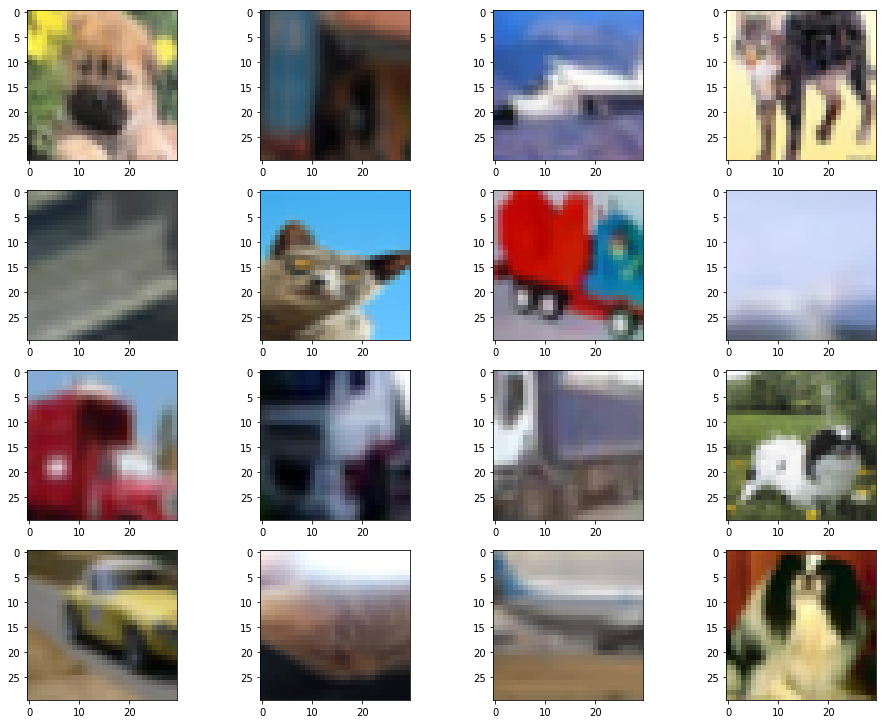

In [43]:
fig=plt.figure(figsize=(16, 16))
for i, batch in enumerate(daliTrainIter):
    imgs, lbls = batch[0]
    #print(imgs[0][0].shape)
    #print(lbls[0].shape)
    img = imgs[0][0].cpu().numpy()
    #print(img)
    fig.add_subplot(5, 4, i+1)
    plt.imshow(img)
    print(LABEL_MAP[int(lbls[0][0].item())])
    #imgs = batch[0]["data"]1
    #lbls = batch[0]["label"].squeeze().cuda().long()
    if i == 15:
        break

In [15]:
CONV_SIZES = [16, 32, 64, 128]
FULLY_SIZES = [CONV_SIZES[-1]*4*4, 1024]
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        convs = []
        fully = []
        convs.append(nn.Conv2d(3, CONV_SIZES[0], 3, padding=2))
        convs.append(nn.BatchNorm2d(CONV_SIZES[0], momentum=BN_MOMENTUM))
        convs.append(Activation())
        convs.append(ResidualUnit(CONV_SIZES[0], CONV_SIZES[0]))
        convs.append(ResidualUnit(CONV_SIZES[0], CONV_SIZES[0]))
        
        convs.append(nn.Conv2d(CONV_SIZES[0], CONV_SIZES[1], CONV_KERNEL, padding=(1, 1)))
        convs.append(nn.BatchNorm2d(CONV_SIZES[1], momentum=BN_MOMENTUM))
        convs.append(Pooling((3,3), stride=(2,2), padding=(1,1)))
        #convs.append(Pooling((2,2), stride=(2,2)))#, padding=(1,1)))
        convs.append(Activation())
        convs.append(ResidualUnit(CONV_SIZES[1], CONV_SIZES[1]))
        convs.append(ResidualUnit(CONV_SIZES[1], CONV_SIZES[1]))
        
        convs.append(nn.Conv2d(CONV_SIZES[1], CONV_SIZES[2], CONV_KERNEL, padding=(1, 1)))
        convs.append(nn.BatchNorm2d(CONV_SIZES[2], momentum=BN_MOMENTUM))
        convs.append(Pooling((3,3), stride=(2,2), padding=(1,1)))
        #convs.append(Pooling((2,2), stride=(2,2)))#, padding=(1,1)))
        convs.append(Activation())
        convs.append(ResidualUnit(CONV_SIZES[2], CONV_SIZES[2]))
        convs.append(ResidualUnit(CONV_SIZES[2], CONV_SIZES[2]))
        
        convs.append(nn.Conv2d(CONV_SIZES[2], CONV_SIZES[3], CONV_KERNEL, padding=(1, 1)))
        convs.append(nn.BatchNorm2d(CONV_SIZES[3], momentum=BN_MOMENTUM))
        convs.append(Pooling((3,3), stride=(2,2), padding=(1,1)))
        #convs.append(Pooling((2,2), stride=(2,2)))#, padding=(1,1)))
        convs.append(Activation())
        #convs.append(ResidualUnit(CONV_SIZES[3]))
        #convs.append(ResidualUnit(CONV_SIZES[3]))
        
        fully.append(nn.Linear(FULLY_SIZES[0], FULLY_SIZES[1]))
        fully.append(nn.BatchNorm1d(FULLY_SIZES[1]))
        fully.append(Activation())
        fully.append(nn.Linear(FULLY_SIZES[1], 10))
        fully.append(nn.Softmax(dim=1))
        
        self.convs = nn.ModuleList(convs)
        self.fully = nn.ModuleList(fully)
        self.eval()
    
    def forward(self, x):
        for layer in self.convs:
            x = layer(x)
        x = x.view(x.shape[0], FULLY_SIZES[0])
        for layer in self.fully:
            x = layer(x)
        return x

In [146]:
# https://github.com/geifmany/cifar-vgg/blob/master/cifar10vgg.py

Activation = nn.ReLU
Pooling = nn.MaxPool2d

class ConvLayer(nn.Module):
    def __init__(self, in_C, out_C, k=CONV_KERNEL, dropout=0.5, **kwargs):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_C, out_C, k, padding=1, **kwargs)
        self.activ = Activation()
        self.bn = nn.BatchNorm2d(out_C, momentum=BN_MOMENTUM)
        self.dropout = nn.Dropout2d(dropout) if dropout > 0 else None
        
    def forward(self, x):
        x = self.conv(x)
        x = self.activ(x)
        x = self.bn(x)
        if self.dropout:
            x = self.dropout(x)
        return x
        
CONV_SIZES = [64, 128, 256, 512]
LAST_SIZE = 1
FULLY_SIZES = [CONV_SIZES[-1]*LAST_SIZE*LAST_SIZE, 512]
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        convs = []
        fully = []
        
        convs.append(ConvLayer(3, CONV_SIZES[0], dropout=0.3))
        convs.append(ConvLayer(CONV_SIZES[0], CONV_SIZES[0], dropout=0))
        convs.append(Pooling(2, stride=2))
        
        convs.append(ConvLayer(CONV_SIZES[0], CONV_SIZES[1], dropout=0.4))
        convs.append(ConvLayer(CONV_SIZES[1], CONV_SIZES[1], dropout=0))
        convs.append(Pooling(2, stride=2))
        
        convs.append(ConvLayer(CONV_SIZES[1], CONV_SIZES[2], dropout=0.4))
        convs.append(ConvLayer(CONV_SIZES[2], CONV_SIZES[2], dropout=0.4))
        convs.append(ConvLayer(CONV_SIZES[2], CONV_SIZES[2], dropout=0))
        convs.append(Pooling(2, stride=2))
        
        convs.append(ConvLayer(CONV_SIZES[2], CONV_SIZES[3], dropout=0.4))
        convs.append(ConvLayer(CONV_SIZES[3], CONV_SIZES[3], dropout=0.4))
        convs.append(ConvLayer(CONV_SIZES[3], CONV_SIZES[3], dropout=0))
        convs.append(Pooling(2, stride=2))
        
        convs.append(ConvLayer(CONV_SIZES[3], CONV_SIZES[3], dropout=0.4))
        convs.append(ConvLayer(CONV_SIZES[3], CONV_SIZES[3], dropout=0.4))
        convs.append(ConvLayer(CONV_SIZES[3], CONV_SIZES[3], dropout=0))
        convs.append(Pooling(2, stride=2))
        convs.append(nn.Dropout2d(0.5))
        
        fully.append(nn.Linear(FULLY_SIZES[0], FULLY_SIZES[1]))
        fully.append(Activation())
        fully.append(nn.BatchNorm1d(FULLY_SIZES[1]))
        fully.append(nn.Dropout(0.5))
        fully.append(nn.Linear(FULLY_SIZES[1], 10))
        fully.append(nn.Softmax(dim=1))
        
        self.convs = nn.ModuleList(convs)
        self.fully = nn.ModuleList(fully)
        self.eval()
    
    def forward(self, x):
        for layer in self.convs:
            x = layer(x)
        x = x.view(x.shape[0], -1)
        for layer in self.fully:
            x = layer(x)
        return x